In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('data/purchase/purchase-train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 602 entries, ID to class
dtypes: int64(602)
memory usage: 45.9 MB


In [3]:
df.head()

,ID,0,1,2,3,4,5,6,7,8,...,591,592,593,594,595,596,597,598,599,class
0,0,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,86
1,1,0,0,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,0,0,81
2,2,0,1,1,1,1,1,1,0,0,...,1,0,1,0,1,0,0,0,0,3
3,3,0,1,0,1,1,1,1,0,0,...,0,1,0,0,1,0,0,0,0,19
4,4,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,76


In [4]:
df.isnull().sum().sum()

0

In [5]:
X_train = df.loc[:, df.columns != 'class']
y_train = df['class']

X_test = pd.read_csv('data/purchase/purchase-xtest.csv')
y_test = pd.read_csv('data/purchase/purchase-ytest.csv')['class']

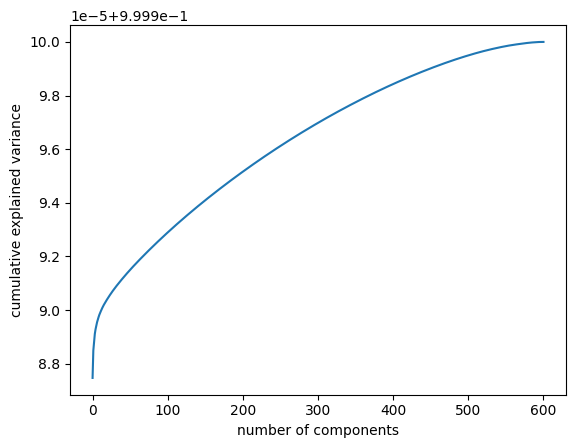

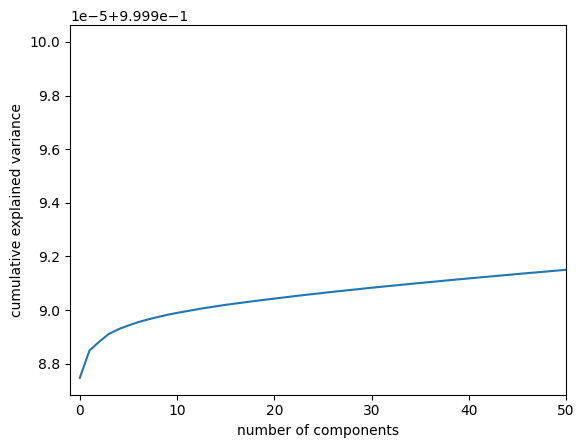

In [6]:
## dimensional reduction
f1 = plt.figure()
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
#plt.clf()

f2 = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim([-1,50])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

plt.show()

pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', PCA(n_components=10)) #step2 - classifier
])

X_train_reduced = pd.DataFrame(pipeline.fit_transform(X_train))

X_test_reduced = pd.DataFrame(pipeline.fit_transform(X_test))

Accuracy: 0.0136
0.27 accuracy with a standard deviation of 0.00
-------------
fit_time  mean  2.620564842224121
fit_time  std  0.07482025307646001
score_time  mean  0.09619112014770508
score_time  std  0.004735947503613332
test_score  mean  0.265
test_score  std  0.0026267851073127416
-------------
10
40
70
100
130
160
190
220
250
280
310
340
370
400
430
460
490


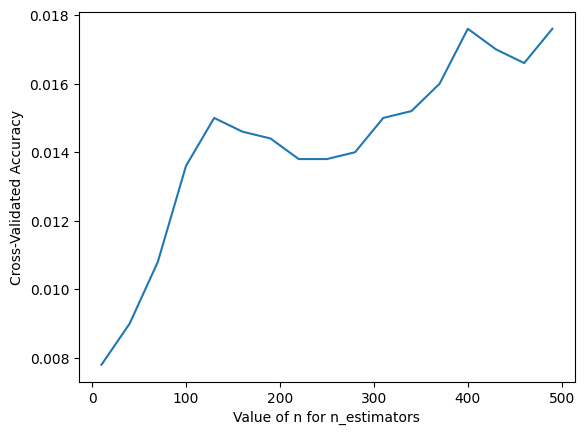

-------------bestN--------
0.0176
400


In [30]:
# random forest classifier - Long running time

#not scaled
forest = RandomForestClassifier(n_estimators=100, random_state=100)
forest.fit(X_train,y_train)
predictions = forest.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))


#CV not scaled
scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print('-------------')
#CV scaled
pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', RandomForestClassifier(n_estimators=100, random_state=100)) #step2 - classifier
])
scores = cross_validate(pipeline, X_train, y_train)
for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
            
## Hyper parameter tuning
print('-------------')
n_range = range(10,500,30)
n_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for n in n_range:
    print(str(n))
    pipeline.set_params(clf__n_estimators=n)
    pipeline.fit(X_train,y_train)
    predictions = pipeline.predict(X_test)
    score = accuracy_score(y_test, predictions)
    n_scores.append(score)
# plot to see clearly
plt.plot(n_range, n_scores)
plt.xlabel('Value of n for n_estimators')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print('-------------bestN--------')

max_acc = max(n_scores)
at_n = n_range[n_scores.index(max_acc)]
print(max_acc)
print(at_n)



In [7]:
## neural network MLPClassifier

#not scaled
mlp = MLPClassifier(hidden_layer_sizes=(50,10,5),random_state=1, max_iter=300,activation = 'relu',solver = 'adam')
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))

#scaled
pipeline.set_params(clf = mlp)
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)
print("Accuracy:",accuracy_score(y_test, predictions))

#reduced scaled frame
print('------------- reduced frame ------')
pipeline.fit(X_train_reduced,y_train)
scores = cross_validate(pipeline, X_train_reduced, y_train)
for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
            
            
# gridSearch on reduced frame
params = [{'clf__hidden_layer_sizes': [(50,10,5), (100,50,20)],
         'clf__max_iter': [300, 500, 1000]}]

gs_mlp = GridSearchCV(pipeline,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_mlp.fit(X_train_reduced, y_train)

print(gs_mlp.best_params_)
print(gs_mlp.score(X_train_reduced, y_train))


Accuracy: 0.0
Accuracy: 0.0086
------------- reduced frame ------


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multi

fit_time  mean  5.876839017868042
fit_time  std  0.19821209680622187
score_time  mean  0.014850568771362305
score_time  std  0.013148344837867565
test_score  mean  0.6071
test_score  std  0.007088018058667758


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multi

{'clf__hidden_layer_sizes': (100, 50, 20), 'clf__max_iter': 500}
0.8951


In [27]:
## linear SVC

#not scaled
clf = SVC(kernel='linear')
clf = clf.fit(X_train_reduced,y_train)
y_pred = clf.predict(X_test_reduced)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred,average='micro'))

#scaled
pipeline.set_params(clf = clf)
pipeline.fit(X_train_reduced,y_train)
y_pred = pipeline.predict(X_test_reduced)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred,average='micro'))

print('--------')
scores = cross_validate(pipeline, X_train_reduced, y_train)
for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())
print('--------')
# gridSearch on reduced frame
params = [{'clf__C': [0.5,1,3],
         'clf__kernel': ['linear', 'poly', 'rbf']}]

gs = GridSearchCV(pipeline,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs.fit(X_train_reduced, y_train)

print(gs.best_params_)
print(gs.score(X_train_reduced, y_train))

results_df = pd.DataFrame(gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]



Accuracy: 0.0092
F1 Score: 0.0092
Accuracy: 0.009
F1 Score: 0.009
--------
fit_time  mean  0.39728684425354005
fit_time  std  0.006493111309439802
score_time  mean  0.9192274570465088
score_time  std  0.003606363307842786
test_score  mean  0.7447
test_score  std  0.006038211655780238
--------
{'clf__C': 1, 'clf__kernel': 'linear'}
0.85


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_linear,"{'clf__C': 1, 'clf__kernel': 'linear'}",1,0.7447,0.006038
3_linear,"{'clf__C': 3, 'clf__kernel': 'linear'}",2,0.7417,0.004729
0.5_linear,"{'clf__C': 0.5, 'clf__kernel': 'linear'}",3,0.7381,0.005324
3_rbf,"{'clf__C': 3, 'clf__kernel': 'rbf'}",4,0.6968,0.006794
1_rbf,"{'clf__C': 1, 'clf__kernel': 'rbf'}",5,0.6791,0.010116
0.5_rbf,"{'clf__C': 0.5, 'clf__kernel': 'rbf'}",6,0.6645,0.010114
3_poly,"{'clf__C': 3, 'clf__kernel': 'poly'}",7,0.6525,0.005822
1_poly,"{'clf__C': 1, 'clf__kernel': 'poly'}",8,0.6268,0.015645
0.5_poly,"{'clf__C': 0.5, 'clf__kernel': 'poly'}",9,0.5764,0.010901
